### Initial Modelling: Random Forest Regression Voting

In this notebook, I'll try to follow the methodology behind Bonefinder which is documented in the following paper: 
- Cootes, T. F., Ionita, M. C., Lindner, C., & Sauer, P. (2012). Robust and accurate shape model fitting using random forest regression voting. In A. Fitzgibbon, S. Lazebnik, P. Perona, Y. Sato, & C. Schmid (Eds.), Computer Vision – ECCV 2012 (pp. 278–291). Springer. https://doi.org/10.1007/978-3-642-33786-4_21

In [2]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#### Loading the data

In [3]:
annotations_path = Path(r"C:\Users\victo\Downloads\OneDrive_2025-10-02\Dataset Kaggle\Annotations")
images_path = Path(r"C:\Users\victo\Downloads\OneDrive_2025-10-02\Dataset Kaggle\Cephalograms")

In [4]:
class CephalometricDataLoader:
    """
    Loads and preprocesses cephalometric images and their landmark annotations.
    Following the paper's approach, we need to:
    1. Load images and annotations
    2. Normalize images to a reference frame
    3. Extract landmarks in a consistent format
    """
    
    def __init__(self, annotations_path, images_path):
        self.annotations_path = Path(annotations_path)
        self.images_path = Path(images_path)
        self.data = []
        
    def load_data(self, max_samples=None):
        """
        Load all images and their corresponding annotations.
        Returns a list of dictionaries with image data and landmarks.
        """
        annotation_files = list(self.annotations_path.glob("*.json"))
        
        if max_samples:
            annotation_files = annotation_files[:max_samples]
            
        print(f"Loading {len(annotation_files)} samples...")
        
        for ann_file in tqdm(annotation_files):
            # Load annotation
            with open(ann_file, 'r') as f:
                ann_data = json.load(f)
            
            # Get corresponding image
            ceph_id = ann_data['ceph_id']
            
            # Try different image extensions
            image_file = None
            for ext in ['.jpg', '.png', '.jpeg', '.JPG', '.PNG']:
                potential_file = self.images_path / f"{ceph_id}{ext}"
                if potential_file.exists():
                    image_file = potential_file
                    break
            
            if image_file is None:
                print(f"Warning: Image not found for ceph_id {ceph_id}")
                continue
            
            # Load image
            image = cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Could not load image {image_file}")
                continue
            
            # Extract landmarks into a more convenient format
            landmarks = {}
            for landmark in ann_data['landmarks']:
                landmarks[landmark['symbol']] = np.array([
                    landmark['value']['x'],
                    landmark['value']['y']
                ])
            
            self.data.append({
                'ceph_id': ceph_id,
                'image': image,
                'landmarks': landmarks,
                'image_path': str(image_file),
                'original_shape': image.shape
            })
        
        print(f"Successfully loaded {len(self.data)} samples")
        return self.data
    
    def visualize_sample(self, idx=0):
        """
        Visualize a sample image with its landmarks.
        This helps us understand our data before processing.
        """
        if not self.data:
            print("No data loaded yet. Call load_data() first.")
            return
        
        sample = self.data[idx]
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        # Display image
        ax.imshow(sample['image'], cmap='gray')
        
        # Plot landmarks
        for symbol, coords in sample['landmarks'].items():
            ax.plot(coords[0], coords[1], 'ro', markersize=3)
            ax.text(coords[0] + 10, coords[1], symbol, 
                   color='yellow', fontsize=8, fontweight='bold')
        
        ax.set_title(f"Cephalogram {sample['ceph_id']} with {len(sample['landmarks'])} landmarks")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    def get_statistics(self):
        """
        Get statistics about the dataset.
        Important for understanding image sizes and landmark distributions.
        """
        if not self.data:
            print("No data loaded yet. Call load_data() first.")
            return
        
        # Image size statistics
        heights = [d['original_shape'][0] for d in self.data]
        widths = [d['original_shape'][1] for d in self.data]
        
        # Landmark statistics
        all_landmarks = set()
        for d in self.data:
            all_landmarks.update(d['landmarks'].keys())
        
        stats = {
            'num_samples': len(self.data),
            'image_heights': {
                'min': min(heights),
                'max': max(heights),
                'mean': np.mean(heights),
                'std': np.std(heights)
            },
            'image_widths': {
                'min': min(widths),
                'max': max(widths),
                'mean': np.mean(widths),
                'std': np.std(widths)
            },
            'landmarks': sorted(list(all_landmarks)),
            'num_landmarks': len(all_landmarks)
        }
        
        return stats

In [5]:
data_loader = CephalometricDataLoader(annotations_path, images_path)

In [6]:
data = data_loader.load_data(max_samples=10)

Loading 10 samples...


100%|██████████| 10/10 [00:00<00:00, 31.99it/s]

Successfully loaded 10 samples


In [7]:
stats = data_loader.get_statistics()
print("\nDataset Statistics:")
print(f"Number of samples: {stats['num_samples']}")
print(f"Image height: {stats['image_heights']['mean']:.0f} ± {stats['image_heights']['std']:.0f} pixels")
print(f"Image width: {stats['image_widths']['mean']:.0f} ± {stats['image_widths']['std']:.0f} pixels")
print(f"Number of landmarks: {stats['num_landmarks']}")
print(f"Landmarks: {stats['landmarks']}")


Dataset Statistics:
Number of samples: 10
Image height: 2400 ± 0 pixels
Image width: 1935 ± 0 pixels
Number of landmarks: 19
Landmarks: ['A', 'ANS', 'Ar', 'B', 'Gn', 'Go', 'LIT', 'Li', 'Ls', 'Me', 'N', 'Or', 'PNS', 'Po', 'Pog', 'Pos', 'S', 'Sn', 'UIT']


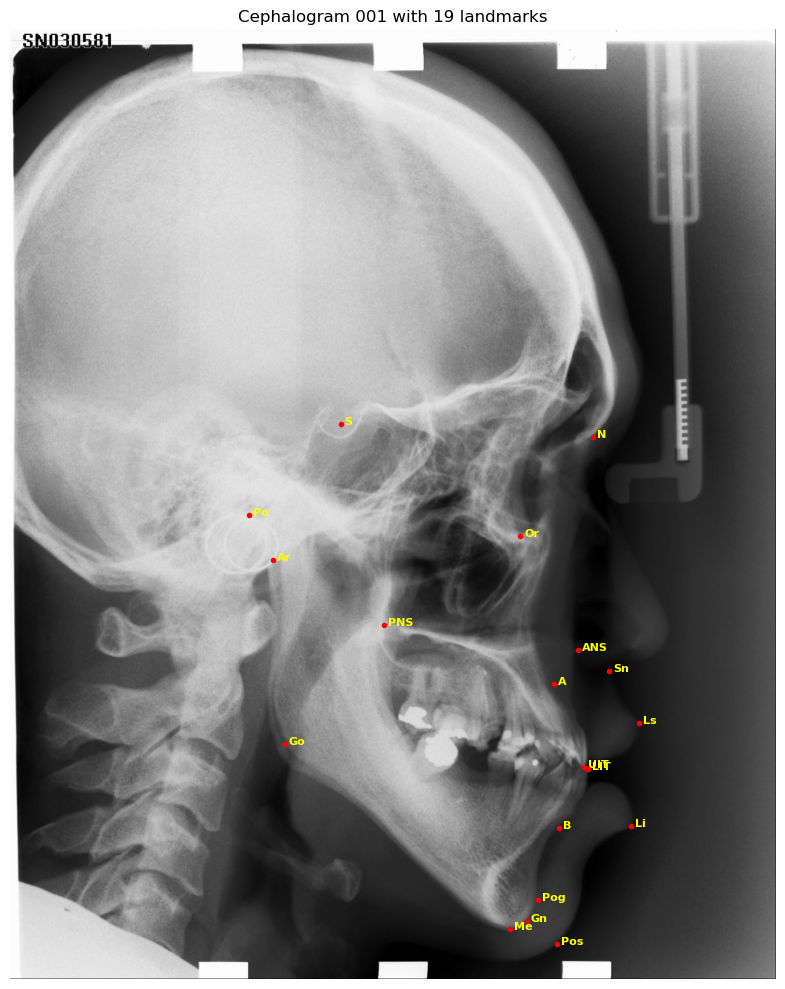

In [8]:
if data:
    data_loader.visualize_sample(0)

#### Data Preprocessing

In [12]:
class ImagePreprocessor:
    """
    Preprocesses images following the RFRV paper approach:
    1. Normalize images to a reference frame (standardized size)
    2. Apply histogram equalization for better feature extraction
    3. Create a shape model for initialization
    """
    
    def __init__(self, reference_width=800):
        """
        Initialize preprocessor.
        
        Args:
            reference_width: Target width for normalized images (paper uses ~70-210 pixels,
                           we'll use 800 for cephalograms which are larger)
        """
        self.reference_width = reference_width
        self.mean_shape = None
        self.shape_model = None
        
    def normalize_image(self, image, landmarks):
        """
        Normalize image to reference frame.
        Following the paper: "Each image is resampled into a standardized reference frame"
        
        Args:
            image: Input grayscale image
            landmarks: Dictionary of landmark positions
            
        Returns:
            normalized_image: Resized image
            normalized_landmarks: Scaled landmark positions
            scale_factor: Scale factor used
        """
        h, w = image.shape
        
        # Calculate scale factor to make width = reference_width
        scale_factor = self.reference_width / w
        
        # Calculate new dimensions
        new_width = self.reference_width
        new_height = int(h * scale_factor)
        
        # Resize image
        normalized_image = cv2.resize(image, (new_width, new_height), 
                                     interpolation=cv2.INTER_LINEAR)
        
        # Scale landmarks
        normalized_landmarks = {}
        for key, coords in landmarks.items():
            normalized_landmarks[key] = coords * scale_factor
        
        return normalized_image, normalized_landmarks, scale_factor
    
    def enhance_image(self, image):
        """
        Apply image enhancement for better feature extraction.
        CLAHE (Contrast Limited Adaptive Histogram Equalization) helps with
        varying contrast in X-ray images.
        """
        # Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
        # Apply CLAHE
        enhanced = clahe.apply(image)
        
        return enhanced
    
    def compute_mean_shape(self, data_list):
        """
        Compute the mean shape from all training samples.
        This is used as initialization for the model fitting process.
        Following paper: "The model is scaled so that the width of the 
        bounding box of the mean shape is a given value"
        """
        all_landmarks = []
        
        # Get all landmarks that are present in ALL samples
        common_landmarks = None
        for sample in data_list:
            # Use normalized_landmarks for preprocessed data
            landmark_dict = sample.get('normalized_landmarks', sample.get('landmarks', {}))
            if common_landmarks is None:
                common_landmarks = set(landmark_dict.keys())
            else:
                common_landmarks = common_landmarks.intersection(landmark_dict.keys())
        
        print(f"Common landmarks across all samples: {sorted(common_landmarks)}")
        
        # Collect all landmark positions
        for sample in data_list:
            # Use normalized_landmarks for preprocessed data
            landmark_dict = sample.get('normalized_landmarks', sample.get('landmarks', {}))
            landmarks_array = []
            for landmark_key in sorted(common_landmarks):
                if landmark_key in landmark_dict:
                    landmarks_array.append(landmark_dict[landmark_key])
            if landmarks_array:
                all_landmarks.append(np.array(landmarks_array))
        
        if not all_landmarks:
            print("Warning: No common landmarks found")
            return None
        
        # Stack and compute mean
        all_landmarks = np.array(all_landmarks)
        self.mean_shape = np.mean(all_landmarks, axis=0)
        
        # Also store which landmarks we're using
        self.landmark_keys = sorted(common_landmarks)
        
        return self.mean_shape, self.landmark_keys
    
    def preprocess_dataset(self, data_list):
        """
        Preprocess entire dataset.
        
        Returns:
            List of preprocessed samples with normalized images and landmarks
        """
        preprocessed_data = []
        
        print("Preprocessing dataset...")
        for sample in tqdm(data_list):
            # Normalize to reference frame
            norm_img, norm_landmarks, scale = self.normalize_image(
                sample['image'], 
                sample['landmarks']
            )
            
            # Enhance image
            enhanced_img = self.enhance_image(norm_img)
            
            preprocessed_data.append({
                'ceph_id': sample['ceph_id'],
                'original_image': sample['image'],
                'normalized_image': norm_img,
                'enhanced_image': enhanced_img,
                'original_landmarks': sample['landmarks'],
                'normalized_landmarks': norm_landmarks,
                'scale_factor': scale,
                'original_shape': sample['original_shape']
            })
        
        # Compute mean shape from normalized landmarks
        self.compute_mean_shape(preprocessed_data)
        
        return preprocessed_data
    
    def visualize_preprocessing(self, original_sample, preprocessed_sample):
        """
        Visualize the preprocessing effects.
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image
        axes[0].imshow(original_sample['image'], cmap='gray')
        axes[0].set_title('Original Image')
        for key, coords in original_sample['landmarks'].items():
            axes[0].plot(coords[0], coords[1], 'ro', markersize=2)
        axes[0].axis('off')
        
        # Normalized image
        axes[1].imshow(preprocessed_sample['normalized_image'], cmap='gray')
        axes[1].set_title('Normalized Image')
        for key, coords in preprocessed_sample['normalized_landmarks'].items():
            axes[1].plot(coords[0], coords[1], 'go', markersize=2)
        axes[1].axis('off')
        
        # Enhanced image
        axes[2].imshow(preprocessed_sample['enhanced_image'], cmap='gray')
        axes[2].set_title('Enhanced (CLAHE) Image')
        for key, coords in preprocessed_sample['normalized_landmarks'].items():
            axes[2].plot(coords[0], coords[1], 'bo', markersize=2)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()


In [13]:
preprocessor = ImagePreprocessor(reference_width=800)

In [14]:
preprocessed_data = preprocessor.preprocess_dataset(data)

Preprocessing dataset...


100%|██████████| 10/10 [00:00<00:00, 919.48it/s]

Common landmarks across all samples: ['A', 'ANS', 'Ar', 'B', 'Gn', 'Go', 'LIT', 'Li', 'Ls', 'Me', 'N', 'Or', 'PNS', 'Po', 'Pog', 'Pos', 'S', 'Sn', 'UIT']


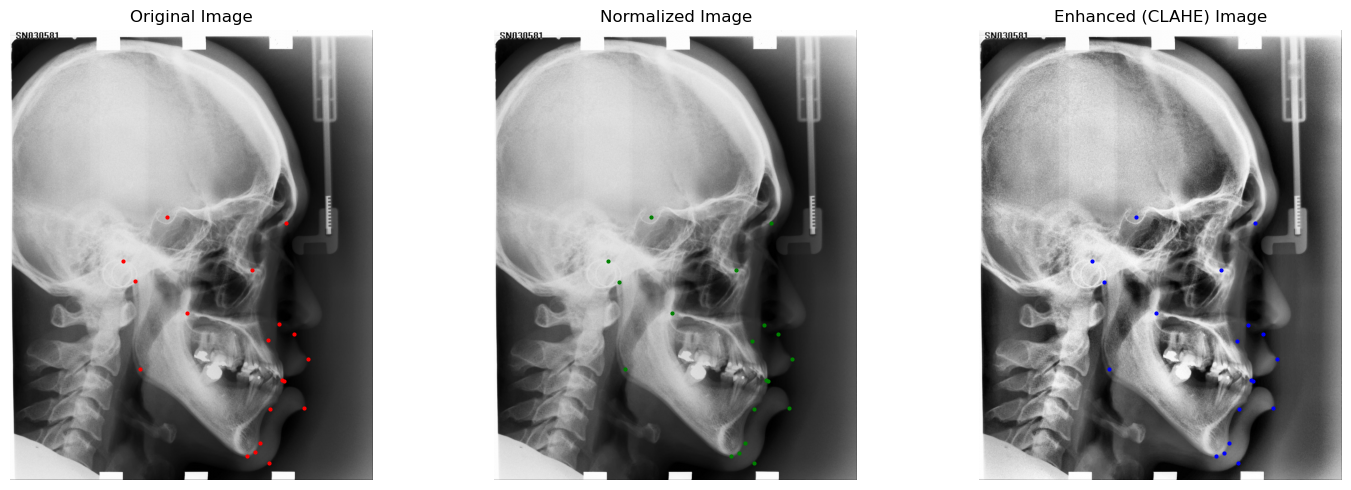


Mean shape computed for 19 landmarks
Landmark keys: ['A', 'ANS', 'Ar', 'B', 'Gn', 'Go', 'LIT', 'Li', 'Ls', 'Me', 'N', 'Or', 'PNS', 'Po', 'Pog', 'Pos', 'S', 'Sn', 'UIT']


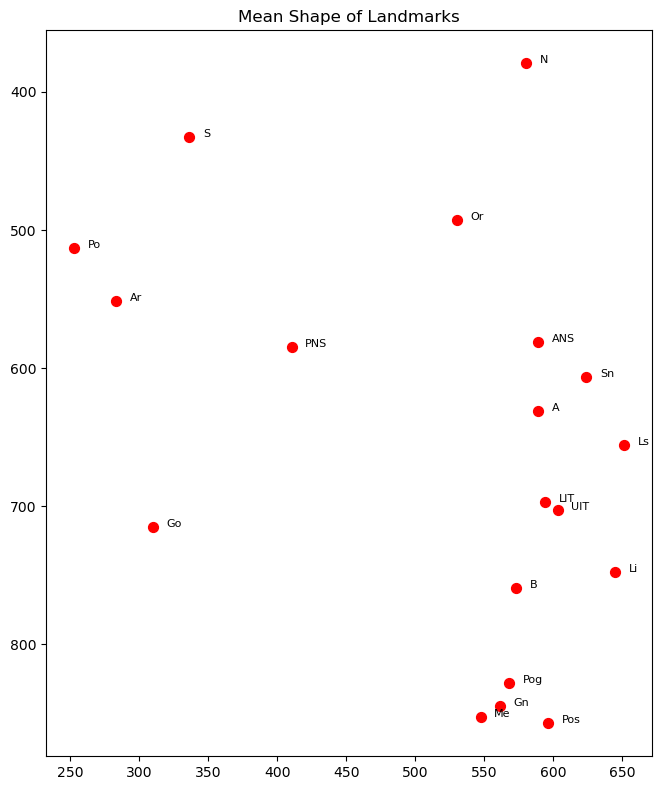

In [15]:
if data and preprocessed_data:
    preprocessor.visualize_preprocessing(data[0], preprocessed_data[0])
    
    # Show mean shape
    if preprocessor.mean_shape is not None:
        print(f"\nMean shape computed for {len(preprocessor.landmark_keys)} landmarks")
        print(f"Landmark keys: {preprocessor.landmark_keys}")
        
        # Visualize mean shape
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.scatter(preprocessor.mean_shape[:, 0], 
                  preprocessor.mean_shape[:, 1], 
                  c='red', s=50)
        for i, key in enumerate(preprocessor.landmark_keys):
            ax.text(preprocessor.mean_shape[i, 0] + 10, 
                   preprocessor.mean_shape[i, 1], 
                   key, fontsize=8)
        ax.set_title("Mean Shape of Landmarks")
        ax.invert_yaxis()  # Invert y-axis to match image coordinates
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.show()

#### RFRV Feature Extraction with Haar-like features

In [16]:
class HaarFeatureExtractor:
    """
    Extracts Haar-like features as described in the paper.
    "We use Haar-like features sampled in a box around the current point,
    as they have been found to be effective for a range of applications 
    and can be calculated efficiently from integral images."
    """
    
    def __init__(self, patch_size=24, num_features=100):
        """
        Initialize the Haar feature extractor.
        
        Args:
            patch_size: Size of the patch around each point (paper uses 13x13 to 24x24)
            num_features: Number of random Haar features to generate
        """
        self.patch_size = patch_size
        self.num_features = num_features
        self.features = []
        self.generate_random_haar_features()
        
    def generate_random_haar_features(self):
        """
        Generate random Haar-like feature configurations.
        We'll use three types:
        1. Two-rectangle features (horizontal and vertical)
        2. Three-rectangle features
        3. Four-rectangle features
        """
        self.features = []
        
        for i in range(self.num_features):
            # Randomly choose feature type
            feature_type = np.random.choice(['two_horizontal', 'two_vertical', 
                                            'three_horizontal', 'three_vertical', 
                                            'four'])
            
            # Generate random positions within patch
            x1 = np.random.randint(0, self.patch_size - 2)
            y1 = np.random.randint(0, self.patch_size - 2)
            
            # Ensure we have at least 2x2 rectangles
            max_width = self.patch_size - x1
            max_height = self.patch_size - y1
            
            width = np.random.randint(2, min(max_width, self.patch_size//2) + 1)
            height = np.random.randint(2, min(max_height, self.patch_size//2) + 1)
            
            self.features.append({
                'type': feature_type,
                'x': x1,
                'y': y1,
                'width': width,
                'height': height
            })
    
    def compute_integral_image(self, image):
        """
        Compute integral image for fast Haar feature calculation.
        Integral image at (x,y) contains sum of all pixels above and to the left.
        """
        return cv2.integral(image)
    
    def extract_patch(self, image, x, y):
        """
        Extract a patch from the image centered at (x, y).
        Handles boundary cases by padding with zeros.
        """
        half_size = self.patch_size // 2
        h, w = image.shape
        
        # Calculate patch boundaries
        x_start = int(x - half_size)
        x_end = int(x + half_size)
        y_start = int(y - half_size)
        y_end = int(y + half_size)
        
        # Create patch with zero padding for out-of-bounds areas
        patch = np.zeros((self.patch_size, self.patch_size), dtype=image.dtype)
        
        # Calculate valid region to copy
        valid_x_start = max(0, x_start)
        valid_x_end = min(w, x_end)
        valid_y_start = max(0, y_start)
        valid_y_end = min(h, y_end)
        
        # Calculate where to place in patch
        patch_x_start = valid_x_start - x_start
        patch_x_end = patch_x_start + (valid_x_end - valid_x_start)
        patch_y_start = valid_y_start - y_start
        patch_y_end = patch_y_start + (valid_y_end - valid_y_start)
        
        # Copy valid region
        if valid_x_end > valid_x_start and valid_y_end > valid_y_start:
            patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = \
                image[valid_y_start:valid_y_end, valid_x_start:valid_x_end]
        
        return patch
    
    def compute_haar_feature(self, integral_patch, feature):
        """
        Compute a single Haar feature value from an integral image patch.
        """
        x, y = feature['x'], feature['y']
        w, h = feature['width'], feature['height']
        
        def rect_sum(x1, y1, x2, y2):
            """Sum of pixels in rectangle using integral image."""
            # Ensure coordinates are within bounds
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(integral_patch.shape[1]-1, x2), min(integral_patch.shape[0]-1, y2)
            
            if x1 >= x2 or y1 >= y2:
                return 0
                
            return (integral_patch[y2, x2] - 
                   integral_patch[y1, x2] - 
                   integral_patch[y2, x1] + 
                   integral_patch[y1, x1])
        
        if feature['type'] == 'two_horizontal':
            # White rectangle - black rectangle (horizontal)
            white = rect_sum(x, y, x + w//2, y + h)
            black = rect_sum(x + w//2, y, x + w, y + h)
            return white - black
            
        elif feature['type'] == 'two_vertical':
            # White rectangle - black rectangle (vertical)
            white = rect_sum(x, y, x + w, y + h//2)
            black = rect_sum(x, y + h//2, x + w, y + h)
            return white - black
            
        elif feature['type'] == 'three_horizontal':
            # White - black - white (horizontal)
            white1 = rect_sum(x, y, x + w//3, y + h)
            black = rect_sum(x + w//3, y, x + 2*w//3, y + h)
            white2 = rect_sum(x + 2*w//3, y, x + w, y + h)
            return white1 - black + white2
            
        elif feature['type'] == 'three_vertical':
            # White - black - white (vertical)
            white1 = rect_sum(x, y, x + w, y + h//3)
            black = rect_sum(x, y + h//3, x + w, y + 2*h//3)
            white2 = rect_sum(x, y + 2*h//3, x + w, y + h)
            return white1 - black + white2
            
        elif feature['type'] == 'four':
            # Checkerboard pattern
            white1 = rect_sum(x, y, x + w//2, y + h//2)
            black1 = rect_sum(x + w//2, y, x + w, y + h//2)
            black2 = rect_sum(x, y + h//2, x + w//2, y + h)
            white2 = rect_sum(x + w//2, y + h//2, x + w, y + h)
            return white1 - black1 - black2 + white2
        
        return 0
    
    def extract_features(self, image, x, y):
        """
        Extract all Haar features for a point (x, y) in the image.
        
        Returns:
            feature_vector: Array of feature values
        """
        # Extract patch
        patch = self.extract_patch(image, x, y)
        
        # Compute integral image of patch
        integral_patch = self.compute_integral_image(patch)
        
        # Compute all Haar features
        feature_values = []
        for feature in self.features:
            value = self.compute_haar_feature(integral_patch, feature)
            feature_values.append(value)
        
        return np.array(feature_values)
    
    def visualize_features(self, image, x, y, num_to_show=9):
        """
        Visualize the Haar features being extracted at a point.
        """
        patch = self.extract_patch(image, x, y)
        
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        axes = axes.flatten()
        
        for i in range(min(num_to_show, len(self.features))):
            ax = axes[i]
            ax.imshow(patch, cmap='gray')
            
            feature = self.features[i]
            
            # Draw rectangles to show Haar feature
            from matplotlib.patches import Rectangle
            
            if feature['type'] in ['two_horizontal', 'two_vertical']:
                # Draw the feature regions
                rect1 = Rectangle((feature['x'], feature['y']), 
                                 feature['width'], feature['height'],
                                 linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect1)
            
            ax.set_title(f"{feature['type']}", fontsize=8)
            ax.axis('off')
        
        plt.suptitle(f"Haar Features at point ({x:.0f}, {y:.0f})")
        plt.tight_layout()
        plt.show()

Extracted 100 features at landmark 'S'
Feature vector shape: (100,)
Feature values range: [-1821.00, 5385.00]


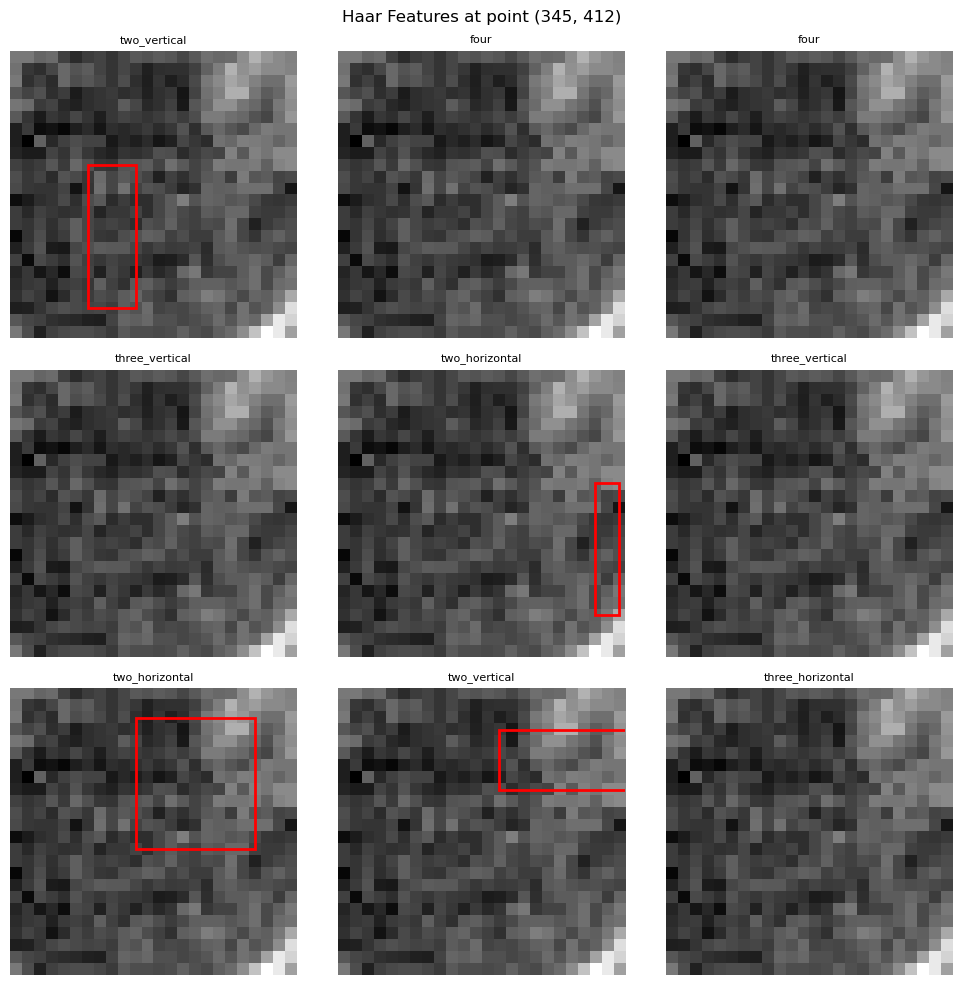

In [17]:
if preprocessed_data:
    # Create feature extractor
    feature_extractor = HaarFeatureExtractor(patch_size=24, num_features=100)
    
    # Get first sample
    sample = preprocessed_data[0]
    image = sample['enhanced_image']
    
    # Extract features at a landmark point
    first_landmark_key = list(sample['normalized_landmarks'].keys())[0]
    landmark_pos = sample['normalized_landmarks'][first_landmark_key]
    
    # Extract features
    features = feature_extractor.extract_features(image, landmark_pos[0], landmark_pos[1])
    
    print(f"Extracted {len(features)} features at landmark '{first_landmark_key}'")
    print(f"Feature vector shape: {features.shape}")
    print(f"Feature values range: [{features.min():.2f}, {features.max():.2f}]")
    
    # Visualize
    feature_extractor.visualize_features(image, landmark_pos[0], landmark_pos[1])

#### RFRV Training Data Generation and Random Forest Training

In [18]:
class RFRVTrainer:
    """
    Implements the Random Forest Regression Voting training process.
    Following the paper: "To train the detector for a single feature point we 
    generate samples by extracting features at a set of random displacements 
    from the true position."
    """
    
    def __init__(self, feature_extractor, max_displacement=15, num_samples_per_image=50):
        """
        Initialize the RFRV trainer.
        
        Args:
            feature_extractor: HaarFeatureExtractor instance
            max_displacement: Maximum displacement for training samples (pixels)
                            Paper uses 5-15 pixels depending on stage
            num_samples_per_image: Number of random samples per landmark per image
        """
        self.feature_extractor = feature_extractor
        self.max_displacement = max_displacement
        self.num_samples_per_image = num_samples_per_image
        self.rf_models = {}  # Store one RF model per landmark
        
    def generate_training_samples(self, preprocessed_data, landmark_key):
        """
        Generate training samples for a specific landmark.
        
        For each image and landmark:
        1. Sample random points around the true landmark position
        2. Extract features at these points
        3. Record the displacement vector from sample point to true landmark
        
        This teaches the model: "When you see these features, the landmark 
        is probably this distance and direction away"
        """
        X_train = []  # Features
        y_train = []  # Displacement vectors (dx, dy)
        
        print(f"Generating training samples for landmark '{landmark_key}'...")
        
        for sample in tqdm(preprocessed_data):
            if landmark_key not in sample['normalized_landmarks']:
                continue
                
            image = sample['enhanced_image']
            true_pos = sample['normalized_landmarks'][landmark_key]
            
            # Generate random displacements
            for _ in range(self.num_samples_per_image):
                # Random displacement within [-max_displacement, +max_displacement]
                dx = np.random.uniform(-self.max_displacement, self.max_displacement)
                dy = np.random.uniform(-self.max_displacement, self.max_displacement)
                
                # Sample point (where we extract features)
                sample_x = true_pos[0] + dx
                sample_y = true_pos[1] + dy
                
                # Skip if sample point is outside image bounds
                h, w = image.shape
                if sample_x < 0 or sample_x >= w or sample_y < 0 or sample_y >= h:
                    continue
                
                # Extract features at sample point
                features = self.feature_extractor.extract_features(image, sample_x, sample_y)
                
                # The target is the displacement FROM the sample point TO the true landmark
                # This is what the model needs to predict: "landmark is here relative to current point"
                target_displacement = np.array([-dx, -dy])  # Negative because we want vector TO landmark
                
                X_train.append(features)
                y_train.append(target_displacement)
        
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        print(f"Generated {len(X_train)} training samples for landmark '{landmark_key}'")
        
        return X_train, y_train
    
    def train_landmark_detector(self, X_train, y_train, landmark_key, 
                               n_trees=10, max_depth=15):
        """
        Train a Random Forest regressor for a specific landmark.
        
        Following the paper: "We train a set of randomised decision trees 
        on the pairs {features, displacement}"
        """
        print(f"Training Random Forest for landmark '{landmark_key}'...")
        print(f"  Training samples: {X_train.shape[0]}")
        print(f"  Features per sample: {X_train.shape[1]}")
        print(f"  Number of trees: {n_trees}")
        
        # Create and train Random Forest
        rf_model = RandomForestRegressor(
            n_estimators=n_trees,
            max_depth=max_depth,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',  # Use sqrt of features at each split
            random_state=42,
            n_jobs=-1  # Use all CPU cores
        )
        
        # Train the model
        rf_model.fit(X_train, y_train)
        
        # Store the trained model
        self.rf_models[landmark_key] = rf_model
        
        # Calculate training error (for monitoring)
        predictions = rf_model.predict(X_train)
        mae = np.mean(np.abs(predictions - y_train))
        rmse = np.sqrt(np.mean((predictions - y_train)**2))
        
        print(f"  Training MAE: {mae:.2f} pixels")
        print(f"  Training RMSE: {rmse:.2f} pixels")
        
        return rf_model
    
    def train_all_landmarks(self, preprocessed_data, landmark_keys=None):
        """
        Train Random Forest models for all landmarks.
        """
        if landmark_keys is None:
            # Use all common landmarks
            landmark_keys = set()
            for sample in preprocessed_data:
                if not landmark_keys:
                    landmark_keys = set(sample['normalized_landmarks'].keys())
                else:
                    landmark_keys = landmark_keys.intersection(sample['normalized_landmarks'].keys())
            landmark_keys = sorted(landmark_keys)
        
        print(f"\nTraining models for {len(landmark_keys)} landmarks...")
        
        for landmark_key in landmark_keys:
            print(f"\n{'='*50}")
            print(f"Training landmark: {landmark_key}")
            print(f"{'='*50}")
            
            # Generate training data
            X_train, y_train = self.generate_training_samples(
                preprocessed_data, landmark_key
            )
            
            if len(X_train) > 0:
                # Train model
                self.train_landmark_detector(X_train, y_train, landmark_key)
            else:
                print(f"Warning: No training samples for landmark '{landmark_key}'")
        
        print(f"\n{'='*50}")
        print(f"Training complete! Trained {len(self.rf_models)} models")
        print(f"{'='*50}")
        
        return self.rf_models
    
    def visualize_displacement_distribution(self, preprocessed_data, landmark_key):
        """
        Visualize the distribution of training displacements for a landmark.
        Helps understand the training data distribution.
        """
        if landmark_key not in preprocessed_data[0]['normalized_landmarks']:
            print(f"Landmark '{landmark_key}' not found")
            return
        
        # Generate some training samples
        X_train, y_train = self.generate_training_samples(
            preprocessed_data[:1],  # Just use first image for visualization
            landmark_key
        )
        
        if len(y_train) == 0:
            print("No training samples generated")
            return
        
        # Plot displacement distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Scatter plot of displacements
        ax1.scatter(y_train[:, 0], y_train[:, 1], alpha=0.5, s=10)
        ax1.set_xlabel('X displacement (pixels)')
        ax1.set_ylabel('Y displacement (pixels)')
        ax1.set_title(f'Training Displacement Distribution for {landmark_key}')
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Add circle to show max displacement
        circle = plt.Circle((0, 0), self.max_displacement, 
                           fill=False, color='red', linestyle='--')
        ax1.add_patch(circle)
        
        # Histogram of displacement magnitudes
        magnitudes = np.sqrt(y_train[:, 0]**2 + y_train[:, 1]**2)
        ax2.hist(magnitudes, bins=30, edgecolor='black')
        ax2.set_xlabel('Displacement magnitude (pixels)')
        ax2.set_ylabel('Count')
        ax2.set_title('Distribution of Displacement Magnitudes')
        ax2.axvline(self.max_displacement, color='red', linestyle='--', 
                   label=f'Max displacement: {self.max_displacement}px')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()

Generating training samples for landmark 'S'...


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]

Generated 50 training samples for landmark 'S'


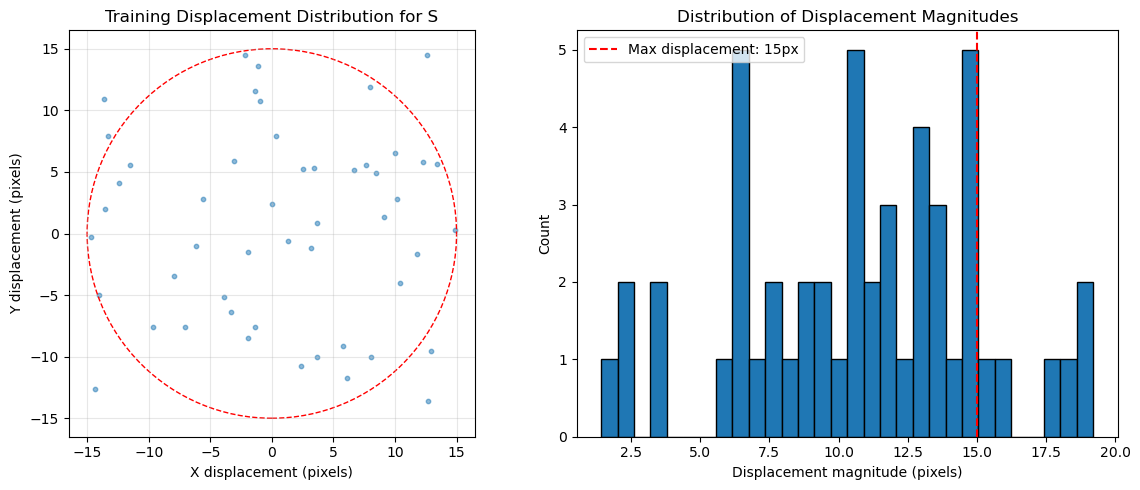


Training on subset of landmarks for testing: ['S', 'N', 'Or']

Training models for 3 landmarks...

Training landmark: S
Generating training samples for landmark 'S'...


100%|██████████| 10/10 [00:00<00:00, 58.06it/s]


Generated 500 training samples for landmark 'S'
Training Random Forest for landmark 'S'...
  Training samples: 500
  Features per sample: 100
  Number of trees: 10
  Training MAE: 2.08 pixels
  Training RMSE: 2.76 pixels

Training landmark: N
Generating training samples for landmark 'N'...


100%|██████████| 10/10 [00:00<00:00, 52.64it/s]


Generated 500 training samples for landmark 'N'
Training Random Forest for landmark 'N'...
  Training samples: 500
  Features per sample: 100
  Number of trees: 10
  Training MAE: 1.91 pixels
  Training RMSE: 2.63 pixels

Training landmark: Or
Generating training samples for landmark 'Or'...


100%|██████████| 10/10 [00:00<00:00, 57.62it/s]


Generated 500 training samples for landmark 'Or'
Training Random Forest for landmark 'Or'...
  Training samples: 500
  Features per sample: 100
  Number of trees: 10
  Training MAE: 2.20 pixels
  Training RMSE: 3.00 pixels

Training complete! Trained 3 models


In [19]:
if preprocessed_data:
    # Initialize trainer with feature extractor
    trainer = RFRVTrainer(
        feature_extractor=feature_extractor,
        max_displacement=15,  # Start with 15 pixels as in paper
        num_samples_per_image=50
    )
    
    # Visualize training data distribution for one landmark
    first_landmark = list(preprocessed_data[0]['normalized_landmarks'].keys())[0]
    trainer.visualize_displacement_distribution(preprocessed_data, first_landmark)
    
    # Train models for first 3 landmarks (for testing - remove limit for full training)
    landmark_subset = list(preprocessed_data[0]['normalized_landmarks'].keys())[:3]
    print(f"\nTraining on subset of landmarks for testing: {landmark_subset}")
    
    trained_models = trainer.train_all_landmarks(
        preprocessed_data, 
        landmark_keys=landmark_subset
    )

#### RFRV Detection with Voting Mechanism

In [20]:
class RFRVDetector:
    """
    Implements the detection phase using Random Forest Regression Voting.
    Following the paper: "At each point, features are sampled. The regressor 
    predicts the most likely position of the target point. The predictions 
    are used to vote for the best position in an accumulator array."
    """
    
    def __init__(self, trainer, feature_extractor, vote_sigma=3.0):
        """
        Initialize the detector.
        
        Args:
            trainer: Trained RFRVTrainer with RF models
            feature_extractor: HaarFeatureExtractor instance
            vote_sigma: Standard deviation for Gaussian voting (pixels)
        """
        self.trainer = trainer
        self.feature_extractor = feature_extractor
        self.vote_sigma = vote_sigma
        
    def detect_landmark(self, image, landmark_key, 
                       search_region=None, step_size=3, 
                       voting_method='gaussian'):
        """
        Detect a single landmark using regression voting.
        
        Args:
            image: Input image (preprocessed)
            landmark_key: Which landmark to detect
            search_region: (x_min, y_min, x_max, y_max) or None for full image
            step_size: Spacing between sample points (paper suggests 3 for speed)
            voting_method: 'single', 'gaussian', or 'weighted'
        
        Returns:
            predicted_position: (x, y) coordinates
            vote_map: The voting accumulator array (heatmap)
        """
        if landmark_key not in self.trainer.rf_models:
            raise ValueError(f"No trained model for landmark '{landmark_key}'")
        
        rf_model = self.trainer.rf_models[landmark_key]
        h, w = image.shape
        
        # Define search region
        if search_region is None:
            x_min, y_min = 0, 0
            x_max, y_max = w, h
        else:
            x_min, y_min, x_max, y_max = search_region
        
        # Initialize vote accumulator
        vote_map = np.zeros((h, w), dtype=np.float32)
        
        # Sample points on a grid with given step size
        # Paper: "Good results can be obtained by evaluating on a sparse grid"
        sample_points_x = range(x_min, x_max, step_size)
        sample_points_y = range(y_min, y_max, step_size)
        
        print(f"Detecting landmark '{landmark_key}'...")
        print(f"  Search region: ({x_min}, {y_min}) to ({x_max}, {y_max})")
        print(f"  Step size: {step_size}")
        print(f"  Sample points: {len(sample_points_x)} x {len(sample_points_y)}")
        
        # For each sample point
        vote_count = 0
        for y in tqdm(sample_points_y, desc="Scanning"):
            for x in sample_points_x:
                # Extract features at this point
                features = self.feature_extractor.extract_features(image, x, y)
                
                # Predict displacement to landmark (returns [dx, dy])
                # This is an ensemble prediction from all trees in the forest
                displacement = rf_model.predict(features.reshape(1, -1))[0]
                
                # Calculate predicted landmark position
                predicted_x = x + displacement[0]
                predicted_y = y + displacement[1]
                
                # Cast vote(s) based on method
                if voting_method == 'single':
                    # Single unit vote at predicted position
                    pred_x_int = int(round(predicted_x))
                    pred_y_int = int(round(predicted_y))
                    
                    if 0 <= pred_x_int < w and 0 <= pred_y_int < h:
                        vote_map[pred_y_int, pred_x_int] += 1
                        vote_count += 1
                        
                elif voting_method == 'gaussian':
                    # Gaussian spread of votes around predicted position
                    # This accounts for uncertainty in the prediction
                    self._add_gaussian_vote(vote_map, predicted_x, predicted_y, 
                                           self.vote_sigma)
                    vote_count += 1
                    
                elif voting_method == 'weighted':
                    # Weight by prediction confidence (using variance from trees)
                    # Get predictions from individual trees
                    tree_predictions = np.array([
                        tree.predict(features.reshape(1, -1))[0] 
                        for tree in rf_model.estimators_
                    ])
                    
                    # Calculate variance as measure of uncertainty
                    variance = np.var(tree_predictions, axis=0)
                    weight = 1.0 / (1.0 + np.sum(variance))  # Lower variance = higher weight
                    
                    pred_x_int = int(round(predicted_x))
                    pred_y_int = int(round(predicted_y))
                    
                    if 0 <= pred_x_int < w and 0 <= pred_y_int < h:
                        vote_map[pred_y_int, pred_x_int] += weight
                        vote_count += 1
        
        print(f"  Cast {vote_count} votes")
        
        # Smooth the vote map slightly to handle discretization
        if voting_method == 'single':
            vote_map = cv2.GaussianBlur(vote_map, (5, 5), 1.0)
        
        # Find peak in vote map
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(vote_map)
        predicted_position = max_loc  # (x, y)
        
        print(f"  Detected position: ({predicted_position[0]:.1f}, {predicted_position[1]:.1f})")
        print(f"  Max votes: {max_val:.2f}")
        
        return predicted_position, vote_map
    
    def _add_gaussian_vote(self, vote_map, center_x, center_y, sigma):
        """
        Add a Gaussian-weighted vote centered at (center_x, center_y).
        """
        h, w = vote_map.shape
        
        # Define region of influence (3 sigma radius)
        radius = int(3 * sigma)
        x_min = max(0, int(center_x - radius))
        x_max = min(w, int(center_x + radius + 1))
        y_min = max(0, int(center_y - radius))
        y_max = min(h, int(center_y + radius + 1))
        
        # Add Gaussian weights
        for y in range(y_min, y_max):
            for x in range(x_min, x_max):
                dist_sq = (x - center_x)**2 + (y - center_y)**2
                weight = np.exp(-dist_sq / (2 * sigma**2))
                vote_map[y, x] += weight
    
    def detect_all_landmarks(self, image, step_size=3):
        """
        Detect all trained landmarks in an image.
        
        Returns:
            Dictionary of landmark positions and vote maps
        """
        results = {}
        
        for landmark_key in self.trainer.rf_models.keys():
            position, vote_map = self.detect_landmark(
                image, landmark_key, step_size=step_size
            )
            results[landmark_key] = {
                'position': position,
                'vote_map': vote_map
            }
        
        return results
    
    def visualize_detection(self, image, landmark_key, true_position=None):
        """
        Visualize the detection process and results.
        """
        # Detect landmark
        predicted_pos, vote_map = self.detect_landmark(
            image, landmark_key, step_size=3, voting_method='gaussian'
        )
        
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image with detection
        axes[0].imshow(image, cmap='gray')
        axes[0].plot(predicted_pos[0], predicted_pos[1], 'r*', 
                    markersize=15, label='Predicted')
        if true_position is not None:
            axes[0].plot(true_position[0], true_position[1], 'g+', 
                        markersize=15, label='True')
            # Calculate error
            error = np.sqrt((predicted_pos[0] - true_position[0])**2 + 
                          (predicted_pos[1] - true_position[1])**2)
            axes[0].set_title(f'Detection (Error: {error:.1f} pixels)')
        else:
            axes[0].set_title('Detection Result')
        axes[0].legend()
        axes[0].axis('off')
        
        # Vote map (heatmap)
        im = axes[1].imshow(vote_map, cmap='hot')
        axes[1].plot(predicted_pos[0], predicted_pos[1], 'b*', markersize=10)
        axes[1].set_title(f'Vote Map for {landmark_key}')
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046)
        
        # Overlay: Image with vote map
        axes[2].imshow(image, cmap='gray', alpha=0.7)
        axes[2].imshow(vote_map, cmap='hot', alpha=0.3)
        axes[2].plot(predicted_pos[0], predicted_pos[1], 'r*', markersize=15)
        if true_position is not None:
            axes[2].plot(true_position[0], true_position[1], 'g+', markersize=15)
        axes[2].set_title('Overlay')
        axes[2].axis('off')
        
        plt.suptitle(f"RFRV Detection for Landmark '{landmark_key}'")
        plt.tight_layout()
        plt.show()
    
    def evaluate_accuracy(self, test_data):
        """
        Evaluate detection accuracy on test data.
        """
        errors = {key: [] for key in self.trainer.rf_models.keys()}
        
        print("\nEvaluating detection accuracy...")
        
        for sample in test_data:
            image = sample['enhanced_image']
            
            for landmark_key in self.trainer.rf_models.keys():
                if landmark_key not in sample['normalized_landmarks']:
                    continue
                
                # Detect landmark
                predicted_pos, _ = self.detect_landmark(
                    image, landmark_key, step_size=5  # Larger step for speed
                )
                
                # Calculate error
                true_pos = sample['normalized_landmarks'][landmark_key]
                error = np.sqrt((predicted_pos[0] - true_pos[0])**2 + 
                              (predicted_pos[1] - true_pos[1])**2)
                errors[landmark_key].append(error)
        
        # Calculate statistics
        print("\nDetection Accuracy Results:")
        print("-" * 50)
        
        for landmark_key in sorted(errors.keys()):
            if errors[landmark_key]:
                err_array = np.array(errors[landmark_key])
                print(f"{landmark_key:15s}: Mean={err_array.mean():.2f} px, "
                      f"Median={np.median(err_array):.2f} px, "
                      f"Std={err_array.std():.2f} px")
        
        return errors

Detecting landmark 'S'...
  Search region: (0, 0) to (800, 992)
  Step size: 3
  Sample points: 267 x 331


Scanning: 100%|██████████| 331/331 [29:50<00:00,  5.41s/it]


  Cast 88377 votes
  Detected position: (343.0, 413.0)
  Max votes: 46.80


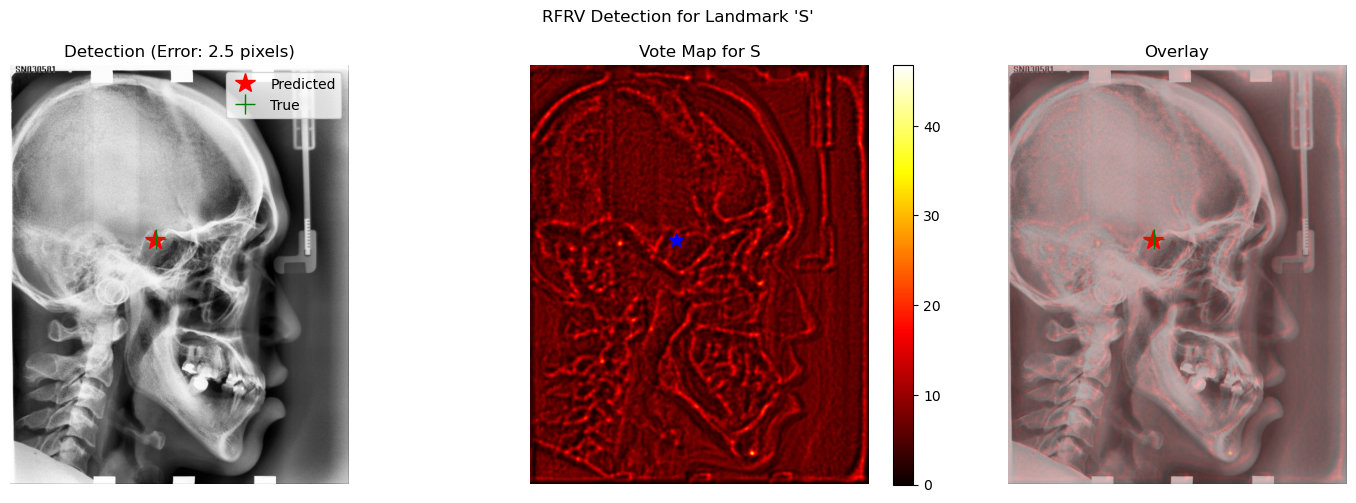

Detecting landmark 'N'...
  Search region: (0, 0) to (800, 992)
  Step size: 3
  Sample points: 267 x 331


Scanning: 100%|██████████| 331/331 [29:25<00:00,  5.33s/it]


  Cast 88377 votes
  Detected position: (609.0, 426.0)
  Max votes: 40.81


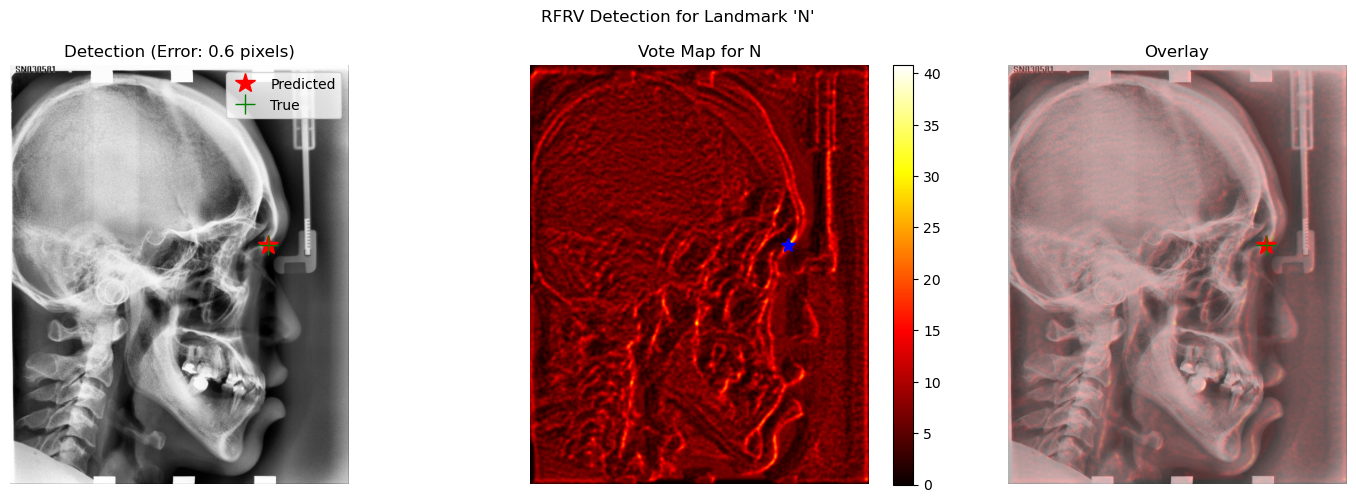


Evaluating detection accuracy...
Detecting landmark 'S'...
  Search region: (0, 0) to (800, 992)
  Step size: 5
  Sample points: 160 x 199


Scanning: 100%|██████████| 199/199 [11:58<00:00,  3.61s/it]


  Cast 31840 votes
  Detected position: (344.0, 413.0)
  Max votes: 16.15
Detecting landmark 'N'...
  Search region: (0, 0) to (800, 992)
  Step size: 5
  Sample points: 160 x 199


Scanning: 100%|██████████| 199/199 [11:43<00:00,  3.53s/it]


  Cast 31840 votes
  Detected position: (610.0, 425.0)
  Max votes: 16.21
Detecting landmark 'Or'...
  Search region: (0, 0) to (800, 992)
  Step size: 5
  Sample points: 160 x 199


Scanning: 100%|██████████| 199/199 [10:39<00:00,  3.22s/it]


  Cast 31840 votes
  Detected position: (531.0, 528.0)
  Max votes: 11.59
Detecting landmark 'S'...
  Search region: (0, 0) to (800, 992)
  Step size: 5
  Sample points: 160 x 199


Scanning: 100%|██████████| 199/199 [10:30<00:00,  3.17s/it]


  Cast 31840 votes
  Detected position: (545.0, 842.0)
  Max votes: 14.25
Detecting landmark 'N'...
  Search region: (0, 0) to (800, 992)
  Step size: 5
  Sample points: 160 x 199


Scanning: 100%|██████████| 199/199 [10:31<00:00,  3.17s/it]


  Cast 31840 votes
  Detected position: (575.0, 405.0)
  Max votes: 14.37
Detecting landmark 'Or'...
  Search region: (0, 0) to (800, 992)
  Step size: 5
  Sample points: 160 x 199


Scanning:   7%|▋         | 13/199 [00:41<09:52,  3.18s/it]


KeyboardInterrupt: 

In [21]:
if preprocessed_data and trainer.rf_models:
    # Create detector
    detector = RFRVDetector(trainer, feature_extractor, vote_sigma=3.0)
    
    # Test on first image
    test_sample = preprocessed_data[0]
    test_image = test_sample['enhanced_image']
    
    # Visualize detection for each trained landmark
    for landmark_key in list(trainer.rf_models.keys())[:2]:  # Show first 2
        if landmark_key in test_sample['normalized_landmarks']:
            true_pos = test_sample['normalized_landmarks'][landmark_key]
            detector.visualize_detection(test_image, landmark_key, true_pos)
    
    # Evaluate accuracy on all preprocessed data
    # Note: In practice, you should split into train/test sets
    accuracy_results = detector.evaluate_accuracy(preprocessed_data)

#### Full Pipeline